In [27]:
import os
import tensorflow as tf
import shutil, sys 
import numpy as np
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [3]:
#Train klasorun içeri/ neg veya pos 
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [16]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

In [4]:
#test ve valid bölmeden içerisinde kesintileri cıkarmak
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
#tekrar kontrol boşluklar alınmış
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [17]:
batch_size = 64
seed = 123
train_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [45]:
#Etiket kontrol
for text_batch, label_batch in train_data.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])

1 b"I thoroughly enjoyed this film for its humor and pathos. I especially like the way the characters welcomed Gina's various suitors. With friends (and family) like these anyone would feel nurtured and loved. I found the writing witty and natural and the actors made the material come alive."
0 b"And a self-admitted one to boot. At one point the doctor's assistant refers to himself as Igor.<br /><br />Working with the increasingly plausible idea that computers could be used to replace or reconstruct brain functions, this movie doesn't spend enough time exploring the premise. Most of the screen time is split between girlfriend-in-a-coma domestic strife and chasing down the brain donor's killer. It attempts to be a sci-fi/drama/thriller but fails to deliver on any of the three.<br /><br />As a Frankenstein remake this one is missing everything that made the original good. Nobody calls the doctor insane or even threatens to kick him out of the hospital. The transformation scene consists o

In [10]:
#data performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#create the text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, label: text))

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but'],
      dtype='<U14')

In [13]:
#3 adet encoded matrix cevrilmiş hali
encoded_batch = encoder(text_batch)[:3].numpy()
encoded_batch

array([[ 10,  26, 279, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0],
       [ 10, 209,   1, ...,   0,   0,   0]], dtype=int64)

RNN model
This model can be build as a tf.keras.Sequential.

The first layer is the encoder, which converts the text to a sequence of token indices.

After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [14]:
#create Model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [15]:
#Model Compile with keraS / BİNAR
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [39]:
start_time = time.time()
history = model.fit(train_data, epochs=10,
                   validation_data=val_data,
                    validation_steps=20)

print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

Epoch 1/10
313/313 [==============================] - 320s 1s/step - loss: 0.2493 - accuracy: 0.8966 - val_loss: 0.3602 - val_accuracy: 0.8297
Epoch 2/10
313/313 [==============================] - 358s 1s/step - loss: 0.2460 - accuracy: 0.8974 - val_loss: 0.3486 - val_accuracy: 0.8516
Epoch 3/10
313/313 [==============================] - 380s 1s/step - loss: 0.2427 - accuracy: 0.8996 - val_loss: 0.3620 - val_accuracy: 0.8406
Epoch 4/10
313/313 [==============================] - 369s 1s/step - loss: 0.2417 - accuracy: 0.8997 - val_loss: 0.3522 - val_accuracy: 0.8523
Epoch 5/10
313/313 [==============================] - 367s 1s/step - loss: 0.2363 - accuracy: 0.9013 - val_loss: 0.3747 - val_accuracy: 0.8445
Epoch 6/10
313/313 [==============================] - 374s 1s/step - loss: 0.2352 - accuracy: 0.9028 - val_loss: 0.4120 - val_accuracy: 0.8305
Epoch 7/10
313/313 [==============================] - 370s 1s/step - loss: 0.2259 - accuracy: 0.9079 - val_loss: 0.3822 - val_accuracy: 0.8453

In [40]:
result = model.evaluate(test_data)
print("Test Accuracy: {:.2f}%".format(result[1] * 100))

313/313 [==============================] - 51s 164ms/step - loss: 0.3739 - accuracy: 0.8474
Test Accuracy: 84.74%


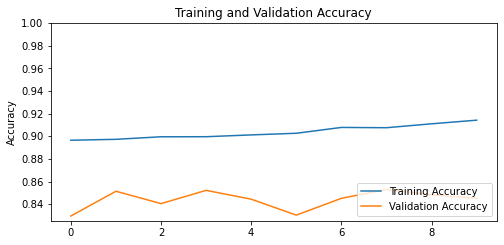

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.show()

In [51]:
#If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('i like this movie')
predictions = np.array(model.predict([sample_text]))
if predictions < 0.0:
    print('Negative')
else:
    print('Positive')
    
print(predictions)

1/1 [==============================] - 0s 23ms/step
Positive
[[0.72436696]]
